<a href="https://colab.research.google.com/github/j-chim/GEM-benchmark.github.io/blob/main/web/data/notebooks/GEM_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
# !pip install git+https://github.com/huggingface/datasets.git
# !pip install rouge_score
# !pip install sentencepiece
# !pip install transformers
# !pip install bert_score
# !pip install seaborn

In [5]:
import torch
from transformers import (
    AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments,T5Model
)
from datasets import load_dataset
from transformers import T5Tokenizer
from datasets import load_metric
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random



## Task 1 – Model Finetuning:

### 1.1 define some hyperparameters

In [3]:
RANDOM_SEED = 42
BEAM_SIZE = 4
DEVICE = "cpu"
MODEL_NAME = "google/t5-v1_1-base"
DATASET_NAME = "e2e_nlg"
MAX_LENGTH = 128
BATCH_SIZE = 20
SAVE_EVAL_STRATEGY = 'epoch'

### 1.2 Loading the data

For assessment 2, we will focus on the **E2E** task.


In [4]:
data_train = load_dataset(DATASET_NAME, split='train[:]')
data_valid = load_dataset(DATASET_NAME, split='validation[:]')

Found cached dataset e2e_nlg (/root/.cache/huggingface/datasets/e2e_nlg/default/0.0.0/bfeceb720929c2705bd227d1cfe5eaaab102a0bdac10dad618dac1e00c737430)
Found cached dataset e2e_nlg (/root/.cache/huggingface/datasets/e2e_nlg/default/0.0.0/bfeceb720929c2705bd227d1cfe5eaaab102a0bdac10dad618dac1e00c737430)



Loading a single example

In [5]:
data_train[5]

{'meaning_representation': 'name[Bibimbap House], food[English], priceRange[moderate], area[riverside], near[Clare Hall]',
 'human_reference': "Bibimbap House is a moderately priced restaurant who's main cuisine is English food. You will find this local gem near Clare Hall in the Riverside area."}

### 1.3 Tokenizing sentences
1. Get all elements from a batch. Then create X data from meaning_representation field, and create Y data from human_reference field

In [6]:
def construct_input_for_batch(batch):
    """Construct input strings from a batch."""
    source = [' '.join(concepts) for concepts in batch["meaning_representation"]]
    target = batch["human_reference"]
    return source, target

2. Use the tokenizer to encode all sentences into vectors.  
The id is the order in the data, and it will be used to match output sentence with input data.  
max_length can be used to add padding in to the sentence.

In [7]:
def batch_tokenize(batch, tokenizer, max_length=32):
    """Construct the batch (source, target) and run them through a tokenizer."""
    source, target = construct_input_for_batch(batch)
#     print('X=',source[0],'Y=',target[0])
    res = {
        "input_ids": tokenizer(source)["input_ids"],
        "labels": tokenizer(
            target,
            padding="max_length",
            truncation=True,
            max_length=max_length
        )["input_ids"],
    }
    return res

3. Here we define a tokenize pipline, in which we fetch batch data from the dataset and return a tokenized data.  
We will send this pipline to the trainer, and it will excute the training process.  
Currently, we only use two sets of data, which are training and validation data.

In [8]:

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

train_data_tokenized = data_train.map(
    lambda batch: batch_tokenize(batch, tokenizer, max_length=MAX_LENGTH),
    batched=True
)
valid_data_tokenized = data_valid.map(
    lambda batch: batch_tokenize(batch, tokenizer, max_length=MAX_LENGTH),
    batched=True
)

Loading cached processed dataset at /root/.cache/huggingface/datasets/e2e_nlg/default/0.0.0/bfeceb720929c2705bd227d1cfe5eaaab102a0bdac10dad618dac1e00c737430/cache-e7f1bbb2f0ccd4f5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/e2e_nlg/default/0.0.0/bfeceb720929c2705bd227d1cfe5eaaab102a0bdac10dad618dac1e00c737430/cache-6d7e0d76f2f18073.arrow


### 1.4 Finetuning a pretrained model

#### 1.4.1  create metric functon 
We use a function to construct another function which will be used during train. After construct the metrics function we return the function and send it to the trainer.

In [9]:
meteor_scorer = load_metric('meteor')

def meteor_metric_builder(tokenizer):
    def compute_meteor_metrics(pred):
        """Utility to compute meteor during training."""
        labels_ids = pred.label_ids
        pred_ids = pred.predictions
        # All special tokens are removed.
        pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
        labels_ids[labels_ids == -100] = tokenizer.pad_token_id
        label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
        # Compute the metric.
        meteor_results = meteor_scorer.compute(predictions=pred_str,
                                       references=label_str)
        return {
            "meteor": round(meteor_results['meteor'], 4),
        }
    return compute_meteor_metrics

meteor_metric_fn = meteor_metric_builder(tokenizer)

/tmp/ipykernel_1925/1771409562.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  meteor_scorer = load_metric('meteor')
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### 1.4.2  load pre-trained T5 model
We get a pre-trained model from huggingface. Then try to fiugure out the current system platform and use the GPU hardware to maxiumize to performance.  

In [10]:

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    DEVICE = torch.ones(1, device=mps_device)
    print(DEVICE)
elif torch.cuda.is_available():
    DEVICE = "cuda:0"
    print(DEVICE)
    
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

cuda:0


#### 1.4.3. Setting hyperparameters and the trainer
1. We can define hyperparameters and send it to the trainer.  
Note that the batch_size means how much data to load into the memory, since T5 is a billion-param-level model, it takes a lot of memory per sentence. As experimented, A machine with 3090ti 24G memory can use the batch size of 24.  
2. we set the metric for best model to meteor to select the beset model during training, and we will discuss the metrics after training.  
3. we can also change learning rate to a bigger number because the dataset is huge and it takes a lot time to train. But we want a good model at the end, smaller learning rate is optional.
4. the train epoch means times that we need to train on the whole dataset.  
5. warmup_rate defines the steps before the starting learning rate, and this will help big models to deal with early overfitting.  


In [11]:
train_args = Seq2SeqTrainingArguments(
    output_dir="t5-v1_1-base-E2E",
    evaluation_strategy=SAVE_EVAL_STRATEGY,
    save_strategy=SAVE_EVAL_STRATEGY,
    logging_steps=5,
    # optimization args, the trainer uses the Adam optimizer
    # and has a linear warmup for the learning rate
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,
    learning_rate=1e-03,
    num_train_epochs=8,
    warmup_steps=1000,
    # misc args
    seed=RANDOM_SEED,
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="meteor",
    # generation
    predict_with_generate=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=train_args,
    train_dataset=train_data_tokenized,
    eval_dataset=valid_data_tokenized,
    tokenizer=tokenizer,
    compute_metrics=meteor_metric_fn,
)

trainer._max_length = MAX_LENGTH
trainer._num_beams = BEAM_SIZE

#### 1.4.4. Tain the model

In [12]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: meaning_representation, human_reference. If meaning_representation, human_reference are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 42061
  Num Epochs = 8
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 16832
  Number of trainable parameters = 247577856


Epoch,Training Loss,Validation Loss,Meteor
1,0.274400,0.239491,0.447100
2,0.201100,0.228684,0.445500
3,0.221800,0.221916,0.434100
4,0.202800,0.219573,0.443300
5,0.167800,0.219734,0.446500
6,0.183300,0.220441,0.441300
7,0.173600,0.223938,0.448800
8,0.167500,0.228972,0.448700


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: meaning_representation, human_reference. If meaning_representation, human_reference are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4672
  Batch size = 20
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config Generat

TrainOutput(global_step=16832, training_loss=0.4814162050469463, metrics={'train_runtime': 6740.1249, 'train_samples_per_second': 49.923, 'train_steps_per_second': 2.497, 'total_flos': 1.1784193100583322e+17, 'train_loss': 0.4814162050469463, 'epoch': 8.0})

## Task 2 – Generate Outputs and Automated Metric Scores. 
### 2.1 create a function that generate sentences form the model
1. we define a function to generate sentences from the trained model.  
2. num_beams means that when the model generating text, it will always choose n best options to continue generating words, instead of always choosing the best one in the manner of greedy search. This would allow the model to find a overall best sentence, but it may need more computation.  
3. max_length defines how long a sentence the model should generate.  


In [13]:
def beam_generate_sentences(batch,
                            model,
                            tokenizer,
                            num_beams=4,
                            max_length=128,
                            device='cuda:0'):
    """Generate outputs from a model with beam search decoding."""
    # Create batch inputs.
    source, _ = construct_input_for_batch(batch)
    # Use the model's tokenizer to create the batch input_ids.
    batch_features = tokenizer(source, padding=True, return_tensors='pt')
    # Move all inputs to the device.
    batch_features = dict([(k, v.to(device))
                           for k, v in batch_features.items()])

    # Generate with beam search.
    generated_ids = model.generate(
        **batch_features,
        num_beams=num_beams,
        max_length=max_length,
    )

    # Use model tokenizer to decode to text.
    generated_sentences = [
        tokenizer.decode(gen_ids.tolist(), skip_special_tokens=True)
        for gen_ids in generated_ids
    ]
    return generated_sentences

### 2.2 We use validation set to get the sentences from the trained model

In [14]:
valid_output = data_valid.map(
    lambda batch: {
        'generated':
        beam_generate_sentences(batch,
                                model,
                                tokenizer,
                                num_beams=BEAM_SIZE,
                                max_length=MAX_LENGTH,
                                device=DEVICE)
    },
    batched=True,
    batch_size=BATCH_SIZE,
)

Map:   0%|          | 0/4672 [00:00<?, ? examples/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

### 2.3 compute rouge score
The rouge score corespond closely to the n-gram algorithm, as it compute its percision, recall and f1 score based on matching n words. Rouge1 compute how much the unigram have been matched in the reference sentence while rouge2 compute how much bigram have been matched. The rougeL means the longest words have match the reference sentence. By n-gram, it means how many consecutive words, bigram coresponding to 2 words, unigram to 1 word.

In [15]:
# Evaluate for ROUGE-2/L
rouge_scorer = load_metric("rouge")

rouge_results = rouge_scorer.compute(
    predictions=valid_output["generated"],
    references=valid_output["human_reference"],
    rouge_types=["rougeL"],
    use_aggregator=True,
    use_stemmer=False,
)
rougeL = rouge_results['rougeL'].mid.fmeasure
f"R-L: {rouge_results['rougeL'].mid.fmeasure:.3f}"

'R-L: 0.513'

In [16]:
rouge_results

{'rougeL': AggregateScore(low=Score(precision=0.4938360243465387, recall=0.5378078785772499, fmeasure=0.5082428585620575), mid=Score(precision=0.49905219360756436, recall=0.5421635870154301, fmeasure=0.5127342117436041), high=Score(precision=0.5043458668505039, recall=0.547896635223449, fmeasure=0.5183524178165027))}

### 2.4 compute meteor score
As mentioned above, rouge is all about n-gram, but the bigest constraint to rouge is that we should choose between rouge-N to specify how many correct consecutive words in sentence is better than the other. However, meteor uses the concept of words chuncks. By counting the number of word chuncks in a sentence we get a better unified sentence to the reference sentence. Furthermore, meteor take the matching word chuncks as penalties. The more word chuncks in a generated sentece the higher penalty it gets, since more chuncks means less unified sentence. Then we combine the unigram-f1 score with the panalty to get the meteor score.

In [17]:
# Evaluate for meteor

meteor_results = meteor_scorer.compute(predictions=valid_output["generated"],
                                       references=valid_output["human_reference"])
meteor = meteor_results['meteor']
meteor_results

{'meteor': 0.6599773137143439}

### 2.5 compute bertscore
Above metrics measure the lexical aspect of the generated sentences, while there are other aspects to consider. Bertscore consider the semantic aspect of the generated sentence, as we may know bert itself is a huge language model specializing in translation. The intuation is that it takes the embedding from already pre-trained bert model to encode both the generated and reference sentences, and then compute the cosine distances between the vectors, so we get a semantically corelation score for each word. The last layer of this process is to add a idf, an algorithm which produce the weighs of each word based on pre-dfined corpus. Finally, we produce a bertscore by aggregating all previous layers.

In [18]:
bertscore = load_metric("bertscore")
bertscore_results = bertscore.compute(predictions=valid_output["generated"],
                                      references=valid_output["human_reference"],
                                      model_type='distilbert-base-uncased')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_tok

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
All the weights of DistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertModel for predictions without further training.


In [19]:
bertscore_results

{'precision': [0.8965519070625305,
  0.9021939039230347,
  0.9032934904098511,
  0.9175271391868591,
  0.916368842124939,
  0.8935747742652893,
  0.9620485901832581,
  0.875855028629303,
  0.9578651189804077,
  0.9596326947212219,
  0.9481502771377563,
  0.8858843445777893,
  0.954099178314209,
  0.9198247194290161,
  0.9331542253494263,
  0.8595209121704102,
  0.8875809907913208,
  0.9572165012359619,
  0.935539722442627,
  0.9924899339675903,
  0.9707400798797607,
  0.9365805387496948,
  0.9217469692230225,
  0.9515746235847473,
  0.7791550755500793,
  0.8383067846298218,
  0.8339824676513672,
  0.8819668889045715,
  0.8819668889045715,
  0.7807134389877319,
  0.8248596787452698,
  0.8946168422698975,
  0.7642863988876343,
  0.8563739061355591,
  0.9407401084899902,
  0.8282166123390198,
  0.9504455327987671,
  0.9299004077911377,
  0.9308269619941711,
  0.8203215599060059,
  0.881345272064209,
  0.8991990685462952,
  0.8980743288993835,
  0.8003593683242798,
  0.8684902787208557,
  

In [20]:
def average(lst):
    return sum(lst) / len(lst)

bert_average_precision = average(bertscore_results['precision'])
bert_average_recall = average(bertscore_results['recall'])
bert_average_f1 = average(bertscore_results['f1'])

f'average_precision: {bert_average_precision}, average_recall: {bert_average_recall},average_f1: {bert_average_f1}'

'average_precision: 0.9041680935387538, average_recall: 0.9077665514682662,average_f1: 0.9056765399107786'

### 2.6 visualize metrics
From the bar chart we can clearly see that rougeL is the the lowest score between them, and each score is higher than the previous one.  This is because rougeL is the most strict measurement among them, using the full word matching technique. However, in the result data we see there are examples that show correct word chuncks, and this makes the meteor score is higher. After my brief inspection in the result, although there are examples that don't match the reference sentence word by word, the meaning of the generated sentences are mostly correct. So, the bertscore is the highest among all other metrics.

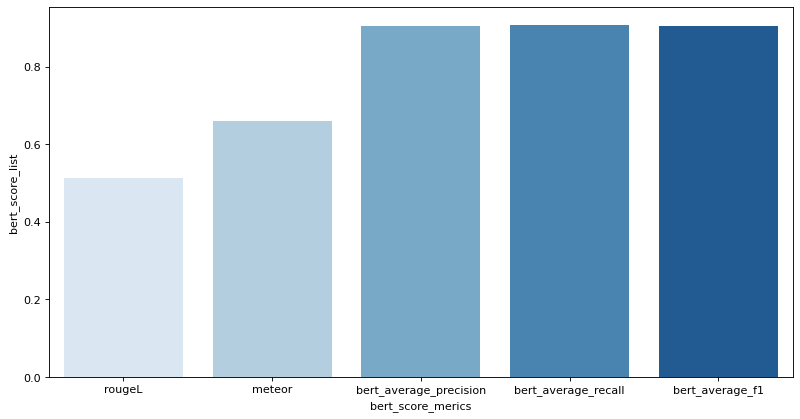

In [21]:
bert_score_merics = [
    "rougeL", "meteor", "bert_average_precision", "bert_average_recall",
    "bert_average_f1"
]
bert_score_list = [
    rougeL, meteor, bert_average_precision, bert_average_recall,
    bert_average_f1
]

dataf = pd.DataFrame({
    "bert_score_merics": bert_score_merics,
    "bert_score_list": bert_score_list
})

plt.figure(figsize=(12, 6), dpi=80)
sns.barplot(x="bert_score_merics",
            y="bert_score_list",
            data=dataf,
            palette='Blues')
plt.show()

In [22]:
random.choice(valid_output)

{'meaning_representation': 'name[Cocum], eatType[coffee shop], food[English], priceRange[high], customer rating[average], familyFriendly[no]',
 'human_reference': 'The Cocum coffee shop is not child friendly and serves English food that is priced high and rated average by customers.',
 'generated': 'Cocum is a coffee shop providing English food in the high price range. It is not children friendly and has an average customer rating.'}

## Task 3 – Human Evaluation
### 3.1 randomly select 25 samples from the out put and save it as a csv file

In [ ]:

def get_random():
    return random.randint(0, len(valid_output) - 1)

In [27]:
validation_list = []
validation_index_list = []

for i in range(0, 25):
    r_index = get_random()
    if r_index in validation_index_list:
        r_index = get_random()
    else:
        validation_index_list.append(r_index)
for index in validation_index_list:
    rouge_results = rouge_scorer.compute(
        predictions=[valid_output[index]["generated"]],
        references=[valid_output[index]["human_reference"]],
        rouge_types=["rougeL"],
        use_aggregator=True,
        use_stemmer=False,
    )
    rougeL = rouge_results['rougeL'].mid.fmeasure

    meteor_results = meteor_scorer.compute(
        predictions=[valid_output[index]["generated"]],
        references=[valid_output[index]["human_reference"]])
    meteor = meteor_results['meteor']

    bertscore_results = bertscore.compute(
        predictions=[valid_output[index]["generated"]],
        references=[valid_output[index]["human_reference"]],
        model_type='bert-base-uncased')
    out_put_dict = {
        "meaning_representation":
        valid_output[index]["meaning_representation"],
        "human_reference": valid_output[index]["human_reference"],
        "generated": valid_output[index]["generated"],
        "rougeL": rougeL,
        "meteor": meteor,
        "bertscore": average(bertscore_results['f1'])
    }
    validation_list.append(out_put_dict)
len(validation_list)

25

In [28]:
df = pd.DataFrame(validation_list)
df.to_csv("human_evaluation.csv")

### 3.2 The result of human evaluation

In [6]:
human_evaluation = pd.read_csv('human_evaluation.csv')

### 3.3 Summary
From the table below, we can see that there are 100 percent matched sentences which are marked as correct accross all metrics along with samples that are low in most metrics proved to be incorrect. There are exceptions, such as the third row, it has a bertscore of 0.83 but it is incorrect. This shads light on the fact that we cannot fully trust neural approaches in NLG at the moment. These high score are merely corelations in the vectors in bertscore since human experts know exactly what does a word mean.  
With regard to human annotatiors, I realize that we cannot make sure that every grammar mistake will be spoted by all annotators, and it is a time-consuming task for a human.

In [12]:
human_evaluation[['rougeL','meteor','bertscore','annotation1','annotation2']]

,rougeL,meteor,bertscore,annotation1,annotation2
0,0.440000,0.543617,0.746972,Correct,correct
1,0.333333,0.638681,0.750349,Correct,correct
2,0.571429,0.611384,0.827512,Correct,correct
3,0.608696,0.682750,0.834356,Context error,correct
4,0.666667,0.857826,0.820544,Correct,Not checkable
5,0.418605,0.830714,0.844769,Correct,correct
6,0.339623,0.687400,0.692583,Context error,correct
7,0.440000,0.641379,0.805484,Correct,correct
8,1.000000,0.999979,1.000000,Correct,correct
9,0.285714,0.700968,0.703326,Correct,correct
